<a href="https://colab.research.google.com/github/ys23-lys/ESAA/blob/main/ESAA_YB_WEEK7_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [코드 필사와 내용 정리]

In [2]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.5
    Uninstalling xgboost-3.0.5:
      Successfully uninstalled xgboost-3.0.5


In [2]:
!pip install lightgbm==4.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0


In [1]:
import xgboost as xgb
print(f"xgboost 버전: {xgb.__version__}")

xgboost 버전: 1.7.6


In [3]:
import lightgbm as lgb
print(f"lightgbm 버전: {lgb.__version__}")

lightgbm 버전: 4.1.0


## 분류 실습 - 캐글 산탄데르 고객 만족 예측

## 데이터 전처리

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
warnings.filterwarnings('ignore')
cust_df=pd.read_csv("/content/drive/MyDrive/Colab/ESAA/train_santander.csv",encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


**피처의 타입과 Null 값 확인**
- 111개의 피처가 float64, 260개의 피처가 int64
- null 값 없음




In [6]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


- 전체 데이터 중 만족과 불만족의 비율

In [7]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


**각 피처의 값 분포 확인**
- var3 칼럼의 min이 -999999 (NaN이나 특정 예외 값을 변환한 것)
   - print(cust_df.var3.value_counts()[:10])으로 var3의 값을 조사했을 때 편차가 심하기 때문에 2로 변환하기
- ID 피처는 단순 식별자이므로 피처 드롭하기

In [8]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


**클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장하기**

In [9]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리.
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


**원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트 분리**

**클래스인 Target값 분포도가 학습 데이터와 테스트 데이터 세트에 비슷하게 추출되었는지 확인하기**
- 불만족 값이 원본 데이터와 유사하게 전체 데이터의 4% 정도로 만들어짐

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_features,y_labels,test_size=0.2,random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


**XGBoost의 조기 중단 검증 데이터 세트로 사용하기 위해 X_train, y_train을 다시 쪼개서 학습과 검증 데이터 세트로 만들기**

In [11]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리.
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.3,random_state=0)

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf=XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,eval_metric="auc",eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

In [13]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space={'max_depth':hp.quniform('max_depth',5,15,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf=XGBClassifier(n_estimators=100,max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        colsample_bytree=search_space['colsample_bytree'],
                        learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]
  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터 세트로 분리
  for tr_index,val_index in kf.split(X_train): # Use X_train here
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]
    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=30,eval_metric="auc",
                eval_set=[(X_tr,y_tr),(X_val,y_val)])
    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val,xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)
  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [15]:
from hyperopt import fmin,tpe,Trials

trials=Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials,rstate=np.random.default_rng(seed=30))

print('best:',best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[21]	validation_0-auc:0.90190	validation_1-auc:0.82629
[22]	validation_0-auc:0.90439	validation_1-auc:0.82729
[23]	validation_0-auc:0.90507	validation_1-auc:0.82820
[24]	validation_0-auc:0.90590	validation_1-auc:0.82771
[25]	validation_0-auc:0.90669	validation_1-auc:0.82847
[26]	validation_0-auc:0.90836	validation_1-auc:0.82965
[27]	validation_0-auc:0.90970	validation_1-auc:0.82947
[28]	validation_0-auc:0.91131	validation_1-auc:0.83014
[29]	validation_0-auc:0.91183	validation_1-auc:0.83063
[30]	validation_0-auc:0.91203	validation_1-auc:0.83035
[31]	validation_0-auc:0.91254	validation_1-auc:0.83014
[32]	validation_0-auc:0.91333	validation_1-auc:0.82944
[33]	validation_0-auc:0.91352	validation_1-auc:0.82935
[34]	validation_0-auc:0.91388	validation_1-auc:0.82896
[35]	validation_0-auc:0.91421	validation_1-auc:0.82882
[36]	validation_0-auc:0.91417	validation_1-auc:0.82852
[37]	validation_0-auc:0.91460	validation_1-auc:0.82793
[38]	validation_0-auc:0.91527

In [16]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf=XGBClassifier(n_estimators=500,learning_rate=round(best['learning_rate'],5),
                      max_depth=int(best['max_depth']),
                      min_child_weight=int(best['min_child_weight']),
                      colsample_bytree=round(best['colsample_bytree'],5))

# evaluation metric을 auc로, early stopping을 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,
            eval_metric="auc",eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81768	validation_1-auc:0.80146
[1]	validation_0-auc:0.81368	validation_1-auc:0.79567
[2]	validation_0-auc:0.83017	validation_1-auc:0.81381
[3]	validation_0-auc:0.83031	validation_1-auc:0.81397
[4]	validation_0-auc:0.83272	validation_1-auc:0.81696
[5]	validation_0-auc:0.83219	validation_1-auc:0.81507
[6]	validation_0-auc:0.82847	validation_1-auc:0.81150
[7]	validation_0-auc:0.83268	validation_1-auc:0.81474
[8]	validation_0-auc:0.83607	validation_1-auc:0.81897
[9]	validation_0-auc:0.83592	validation_1-auc:0.81875
[10]	validation_0-auc:0.83358	validation_1-auc:0.81472
[11]	validation_0-auc:0.83711	validation_1-auc:0.81823
[12]	validation_0-auc:0.83986	validation_1-auc:0.81989
[13]	validation_0-auc:0.83873	validation_1-auc:0.81973
[14]	validation_0-auc:0.84028	validation_1-auc:0.82043
[15]	validation_0-auc:0.83924	validation_1-auc:0.81929
[16]	validation_0-auc:0.83738	validation_1-auc:0.81654
[17]	validation_0-auc:0.83631	validation_1-auc:0.81409
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

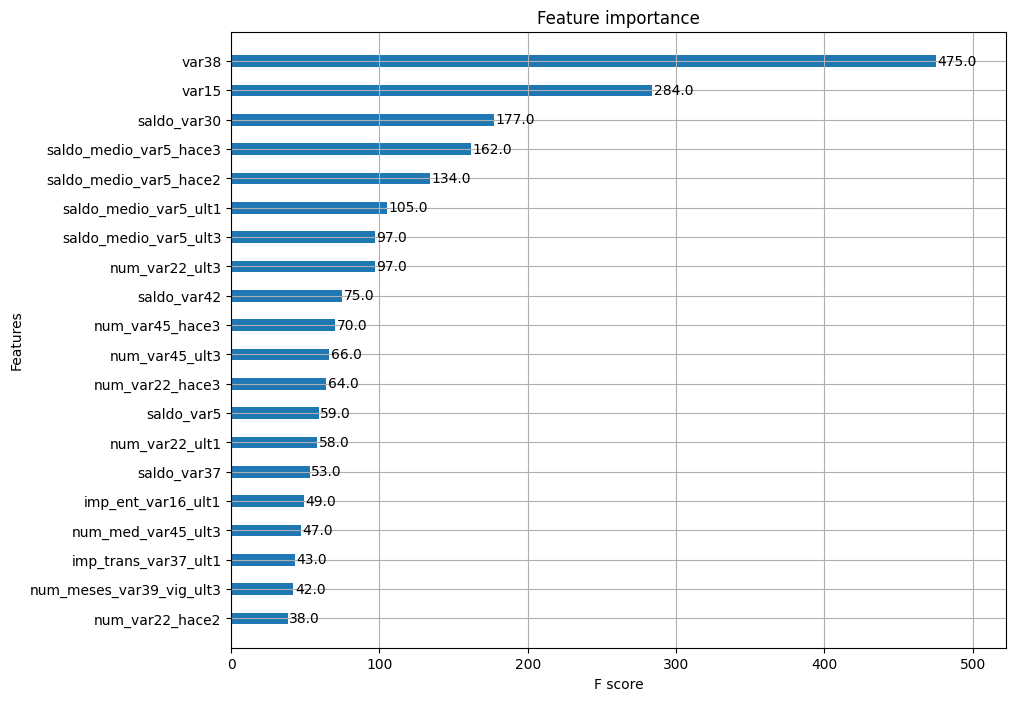

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [18]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping # Import early_stopping

lgbm_clf=LGBMClassifier(n_estimators=500)

eval_set=[(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.fit(X_tr,y_tr,
            callbacks=[early_stopping(stopping_rounds=100, verbose=True)], # Use callbacks instead of early_stopping_rounds
            eval_metric="auc",eval_set=eval_set)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.91059	training's binary_logloss: 0.112183	valid_1's auc: 0.831787	valid_1's binary_logloss: 0.13527
ROC AUC:0.8384


In [19]:
lgbm_search_space={'num_leaves':hp.quniform('num_leaves',32,64,1),
                   'max_depth':hp.quniform('max_depth',100,160,1),
                   'min_child_samples':hp.quniform('min_child_samples',60,100,1),
                   'subsample':hp.uniform('subsample',0.7,1),
                   'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [20]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping # Import early_stopping
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np # Import numpy

def objective_func(search_space):
  lgbm_clf=LGBMClassifier(n_estimators=100,
                          num_leaves=int(search_space['num_leaves']),
                          max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                          subsample=search_space['subsample'],
                          learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]
  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index,val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]
    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
    lgbm_clf.fit(X_tr,y_tr,callbacks=[early_stopping(stopping_rounds=30, verbose=False)],eval_metric="auc",
                 eval_set=[(X_tr,y_tr),(X_val,y_val)])
    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결갏값 담음.
    score=roc_auc_score(y_val,lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)
  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [21]:
from hyperopt import fmin,tpe,Trials

trials=Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,space=lgbm_search_space,algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials,rstate=np.random.default_rng(seed=30))

print('best:',best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13008
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 197
[LightGBM] [Info

In [22]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping # Import early_stopping
from sklearn.metrics import roc_auc_score

lgbm_clf=LGBMClassifier(n_estimators=500,num_leaves=int(best['num_leaves']),
                        max_depth=int(best['max_depth']),
                        min_child_samples=int(best['min_child_samples']),
                        subsample=round(best['subsample'],5),
                        learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr,y_tr,callbacks=[early_stopping(stopping_rounds=100, verbose=True)],
             eval_metric="auc",eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1]) # Corrected to use lgbm_clf
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.899119	training's binary_logloss: 0.11717	valid_1's auc: 0.833934	valid_1's binary_logloss: 0.13474
ROC AUC:0.8412


## 분류 실습 - 캐글 신용카드 사기 검출

## 언더 샘플링과 오버 샘플링의 이해

지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해 적절한 학습 데이터를 확보하기 위한 방안
- 오버 샘플링(Oversampling), 언더 샘플링(Undersampling)

**언더 샘플링**: 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소

**오버 샘플링**: 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
- **SMOTE**(Synthetic Minority Over-Sampling Technique): 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 방식

In [ ]:
# conda install -c conda-forge imbalanced-learn

In [24]:
%pip install imbalanced-learn

## 데이터 일차 가공 및 모델 학습/예측/평가
- V로 시작하는 피처: 의미를 알 수 없음
- Time 피처: 데이터 생성 관련한 작업용 속성 -> 제거
- Amount 피처: 신용카드 트랜잭션 금액
- Class: 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션

card_df.info()로 확인하면
- 결측치 없음
- Class 레이블만 int형, 나머지 피처는 모두 float형

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv("/content/drive/MyDrive/Colab/ESAA/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [26]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [28]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train,X_test,y_train,y_test=\
  train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

In [29]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1： {3:.4f}, AUC：{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [31]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=1000)
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1： 0.7194, AUC：0.9741


In [32]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)

In [33]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

## 데이터 분포도 변환 후 모델 학습/예측/평가

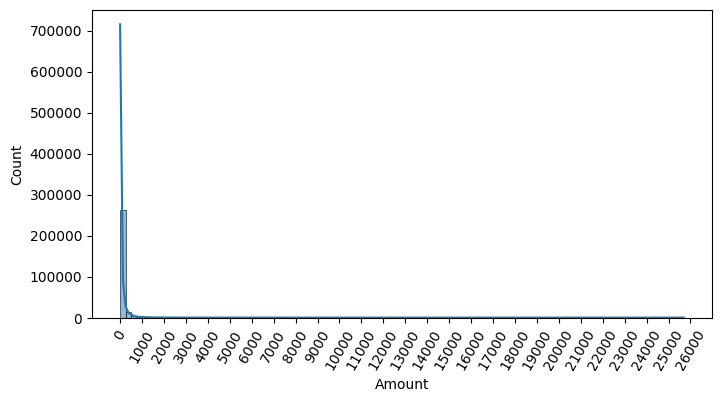

In [34]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [36]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1： 0.7294, AUC：0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [38]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [41]:
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1： 0.7120, AUC：0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

## 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터: 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- IQR(Inter Quantile Range): 사분위 값 편차를 이용하는 기법. IQR에 1.5를 곱해 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주.

<Axes: >

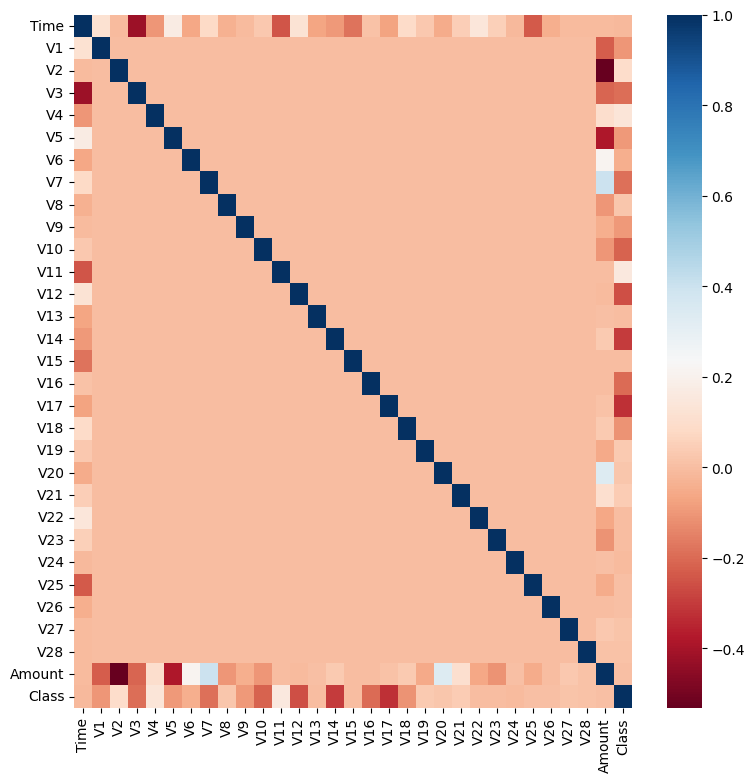

In [42]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [46]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)
  # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index=fraud[(fraud<lowest_val) | (fraud>highest_val)].index
  return outlier_index

In [47]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [49]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1： 0.7568, AUC：0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [50]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 Class
0    199020
1    199020
Name: count, dtype: int64


In [51]:
lr_clf=LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1： 0.1022, AUC：0.9736


In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

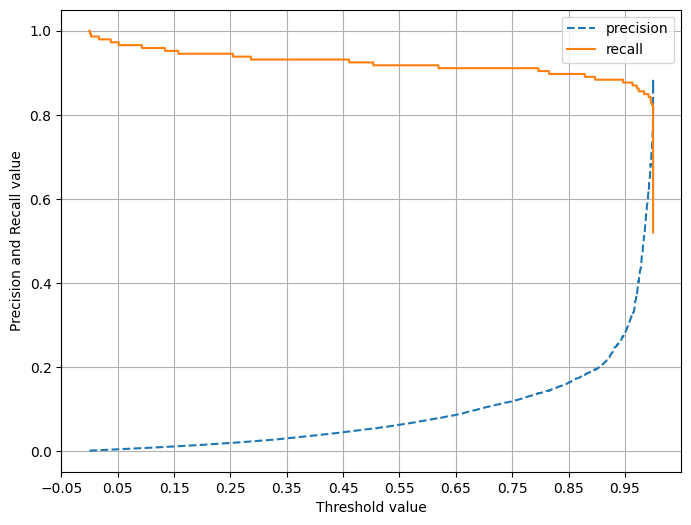

In [53]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [54]:
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split